Epoch 1/10


2023-12-03 12:11:05.771407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 7354.3906 - accuracy: 0.0201

2023-12-03 12:11:07.820384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 3s 112ms/step - loss: 7354.3906 - accuracy: 0.0201 - val_loss: 7638.4956 - val_accuracy: 0.0345
Epoch 2/10
11/11 [==============================] - 0s 35ms/step - loss: 7859.6094 - accuracy: 0.0345 - val_loss: 7638.4956 - val_accuracy: 0.0345
Epoch 3/10
11/11 [==============================] - 0s 32ms/step - loss: 7859.6094 - accuracy: 0.0345 - val_loss: 7638.4956 - val_accuracy: 0.0345
Epoch 4/10
11/11 [==============================] - 0s 30ms/step - loss: 7859.6094 - accuracy: 0.0345 - val_loss: 7638.4956 - val_accuracy: 0.0345
Epoch 5/10
11/11 [==============================] - 0s 31ms/step - loss: 7859.6094 - accuracy: 0.0345 - val_loss: 7638.4956 - val_accuracy: 0.0345
Epoch 6/10
11/11 [==============================] - 0s 32ms/step - loss: 7859.6099 - accuracy: 0.0345 - val_loss: 7638.4956 - val_accuracy: 0.0345
Epoch 7/10
11/11 [==============================] - 0s 33ms/step - loss: 7859.6094 - accuracy: 0.0345 - val_loss: 7638.4956 - va

2023-12-03 12:11:12.620350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 15ms/step


/Users/zhaochengxin/anaconda3/envs/Learn/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (32). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


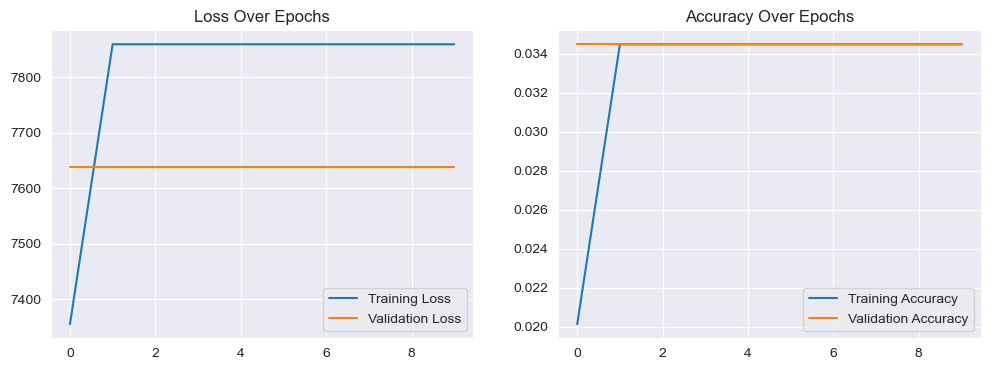

4/4 [==============================] - 0s 21ms/step
Confusion Matrix:
[[0 0 0 ... 0 0 5]
 [0 0 0 ... 0 0 2]
 [0 0 0 ... 0 0 2]
 ...
 [0 0 0 ... 0 0 2]
 [0 0 0 ... 0 0 4]
 [0 0 0 ... 0 0 4]]


/var/folders/fm/_6wfn0r96gjcpy7779d0j2fc0000gn/T/ipykernel_36569/1362144059.py:114: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common = mode(predicted_labels[mask])[0][0]


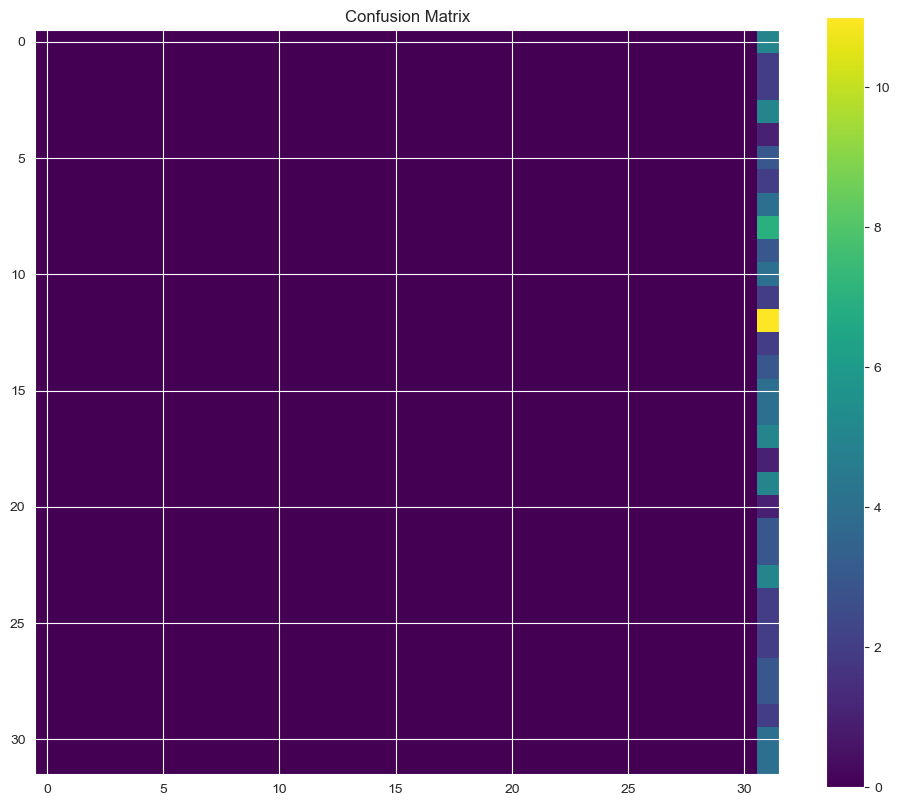

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         7
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        11
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         4
    

/Users/zhaochengxin/anaconda3/envs/Learn/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zhaochengxin/anaconda3/envs/Learn/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zhaochengxin/anaconda3/envs/Learn/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

In [89]:
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
import glob
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture
from keras.models import Sequential
from keras.layers import Dense, Flatten
import matplotlib.pyplot as plt
from scipy.stats import mode
import tensorflow as tf



# 数据预处理
def load_images(image_paths, target_size=(256, 256)):
    images = []
    labels = []

    for image_path in image_paths:
        image = Image.open(image_path).convert('RGB').resize(target_size)
        image = np.array(image) / 255.0
        label = image_path.split('/')[-2]
        images.append(image)
        labels.append(label)

    return np.array(images), np.array(labels)


# ANN模型，使用自定义的categorical_cross_entropy_loss

class ANNModel:
    def __init__(self, input_shape, num_classes):
        self.model = Sequential([
            Flatten(input_shape=input_shape),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])
        self.model.compile(optimizer='adam', loss=self.categorical_cross_entropy_loss, metrics=['accuracy'])

    def categorical_cross_entropy_loss(self, y_true, y_pred):
        # 将 y_true 转换为浮点数类型
        y_true = tf.cast(y_true, tf.float32)
        epsilon = 1e-7  # 防止对数运算中的数值不稳定
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)  # 将预测值限制在 epsilon 和 1-epsilon 之间
        loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
        return tf.reduce_mean(loss)

    def train(self, X, y):
        history = self.model.fit(X, y, epochs=10, validation_split=0.2)
        return history

    def predict(self, X):
        return self.model.predict(X)

# 无监督模型 (GMM)
class UnsupervisedGMM:
    def __init__(self, n_components):
        self.model = GaussianMixture(n_components=n_components)

    def fit(self, X):
        self.model.fit(X)

    def predict(self, X):
        return self.model.predict(X)


# Ensemble模型
class EnsembleModel:
    def __init__(self, supervised_model, unsupervised_model):
        self.supervised_model = supervised_model
        self.unsupervised_model = unsupervised_model

    def fit(self, X, y):
        history = self.supervised_model.train(X, y)
        features = self.supervised_model.predict(X)
        self.unsupervised_model.fit(features)
        return history

    def predict(self, X):
        features = self.supervised_model.predict(X)
        return self.unsupervised_model.predict(features)


# 可视化训练历史
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()
    plt.show()


# 重新映射聚类标签以匹配真实标签
def remap_labels(true_labels, predicted_labels):
    unique_true_labels = np.unique(true_labels)
    mapped_labels = np.zeros_like(predicted_labels)
    for true_label in unique_true_labels:
        mask = (true_labels == true_label)
        # Find the cluster label that most frequently occurs with this true label
        most_common = mode(predicted_labels[mask])[0][0]
        mapped_labels[predicted_labels == most_common] = true_label
    return mapped_labels


# 加载数据和训练模型
image_paths = glob.glob('Car_Logo_Dataset/**/*.png', recursive=True)
X, y = load_images(image_paths)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# 构建模型
ann_model = ANNModel(X_train[0].shape, len(np.unique(y_train)))
gmm_model = UnsupervisedGMM(n_components=len(np.unique(y_train)))
ensemble_model = EnsembleModel(ann_model, gmm_model)

# 训练模型
history = ensemble_model.fit(X_train, y_train)

# 可视化损失和准确率
plot_history(history)

# 进行预测
features_test = ann_model.predict(X_test)  # 先通过ANN获得特征
predicted_clusters = gmm_model.predict(features_test)  # 用GMM进行聚类预测
mapped_predictions = remap_labels(y_test, predicted_clusters)  # 重新映射聚类标签

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_test, mapped_predictions)
print('Confusion Matrix:')
print(conf_matrix)

# 绘制混淆矩阵
plt.figure(figsize=(12, 10))
plt.imshow(conf_matrix, cmap='viridis')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()

# 输出分类报告
print('Classification Report:')
print(classification_report(y_test, mapped_predictions))

# 计算准确率
accuracy = np.sum(mapped_predictions == y_test) / len(y_test)
print(f'Clustering Accuracy: {accuracy}')

In [ ]:
def visualize_clusters_with_labels(X, y, model, perplexity=30, learning_rate=200):
    # 通过神经网络模型提取特征
    features = model.predict(X)

    # 使用t-SNE降维到二维
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, random_state=42)
    X_reduced = tsne.fit_transform(features)

    # 绘制所有聚类的散点图
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis', alpha=0.6)

    # 为每个聚类的质心添加注释
    # 如果聚类数量很多，这可能会导致图表拥挤
    # unique_labels = np.unique(y)
    # for i, label in enumerate(unique_labels):
    #     xtext, ytext = np.median(X_reduced[y == label, :], axis=0)
    #     txt = f'Cluster {label}'
    #     plt.annotate(txt, (xtext, ytext), fontsize=9, ha='center')

    # 如果你想为每个点标注标签，取消注释以下代码
    for i, txt in enumerate(y):
        plt.annotate(txt, (X_reduced[i, 0], X_reduced[i, 1]), fontsize=8, alpha=0.7)

    plt.legend(handles=scatter.legend_elements()[0], labels=set(y), title="Clusters")
    plt.title('t-SNE visualization with labeled clusters')
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')
    plt.show()


visualize_clusters_with_labels(X_test, mapped_predictions, ann_model)

4/4 [==============================] - 0s 16ms/step


In [ ]:
# from sklearn.metrics import adjusted_rand_score
# 
# adjusted_rand_index = adjusted_rand_score(y_test, predictions)
# print("调整后的兰德指数：", adjusted_rand_index)

In [ ]:
# from sklearn.metrics import normalized_mutual_info_score
# 
# normalized_mutual_info = normalized_mutual_info_score(y_test, predictions)
# print("标准化互信息：", normalized_mutual_info)